In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.preprocessing import LabelEncoder

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import shap


In [2]:
# Load and preprocess the data
df = pd.read_csv("dungeon performance ranks 28.01 - 24.02.csv")  # Replace with your data file path

# Step 1: Order runs by time and calculate churn
df = df.sort_values(by=["userId", "entryTime"])

df["is_last_run"] = df.groupby("userId")["rn"].transform("max") == df["rn"]

# Identify churn events (e.g., is_last_run = True)
df["churn_event"] = df["is_last_run"].astype(int)

# Group by user and compute runs_to_churn using reverse cumulative sum
df["runs_to_churn"] = df.groupby("userId")["rn"].transform("max") - df["rn"]


# Map to categories (if needed)
df["runs_to_churn_category"] = df["runs_to_churn"].astype("category")


# Step 2: Calculate 'runs_to_churn' for each user
#df["runs_to_churn"] = df.groupby("userId")["rn"].transform("max") - df["rn"]



In [3]:
df

,userId,dungeonId,sessionId,eventType,PartyMembers,entryTime,exitTime,duration,gameTime,min_fps,...,max_ping,p25_ping,median_ping,p75_ping,p90_ping,rn,is_last_run,churn_event,runs_to_churn,runs_to_churn_category
46145,01HV74Y9CEMS2PHHPT5YN624RC,dc_desert_tier1,01JJW7HGNCJVE5CK036E4FH77M,abandoned,1,2025-01-30 18:28:37.5 UTC,2025-01-30 18:31:08.5 UTC,0-0 0 0:2:31,129,126.077148,...,171.525,106.320,110.655,113.360,119.625,1,False,0,5,5
68010,01HV74Y9CEMS2PHHPT5YN624RC,dc_desert_tier1,01JK901PGN3V04EG85HDVD40QH,abandoned,1,2025-02-04 17:27:41.499 UTC,2025-02-04 17:31:24.499 UTC,0-0 0 0:3:43,159,105.988889,...,173.730,108.010,109.790,115.980,122.555,2,False,0,4,4
81232,01HV74Y9CEMS2PHHPT5YN624RC,dc_desert_gd_1,01JK908WHF8HE5K83NCGG2709D,abandoned,1,2025-02-04 17:31:37.499 UTC,2025-02-04 17:32:45.5 UTC,0-0 0 0:1:8.001,62,60.746161,...,131.740,113.750,127.550,128.335,131.740,3,False,0,3,3
88804,01HV74Y9CEMS2PHHPT5YN624RC,dc_desert_25_man_boss,01JK90BMGFNZF84TFB206KBJCQ,abandoned,1,2025-02-04 17:33:07.5 UTC,2025-02-04 17:34:18.5 UTC,0-0 0 0:1:11,70,132.709449,...,120.605,102.765,110.100,119.650,120.605,4,False,0,2,2
93193,01HV74Y9CEMS2PHHPT5YN624RC,dc_desert_25_man_boss,01JKKFH2WJFWXTM2XB9B8THYRF,abandoned,1,2025-02-08 19:10:45.5 UTC,2025-02-08 19:11:25.5 UTC,0-0 0 0:0:40,30,99.947061,...,173.490,110.210,111.035,144.235,173.490,5,False,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20986,01JMVV9QGF7C4BES3B0JQ9TBF2,dc_tutorial_tier1,01JMVVC49AEJDYT4QB4PY8KBS3,died,1,2025-02-24 11:27:16.499 UTC,2025-02-24 11:28:24.5 UTC,0-0 0 0:1:8.001,60,64.176838,...,353.600,252.300,253.000,335.800,353.600,1,False,0,1,1
53376,01JMVV9QGF7C4BES3B0JQ9TBF2,dc_tutorial_tier1,01JMVVFE1XP04394P5W6HDSMZ0,died,1,2025-02-24 11:29:10.499 UTC,2025-02-24 11:30:15.5 UTC,0-0 0 0:1:5.001,63,96.675167,...,306.300,251.800,267.800,270.200,306.300,2,True,1,0,0
38905,01JMVVKG26PDEY2NV41ZTWSBP1,dc_tutorial_tier1,01JMVVWSKT2QAVGZY5KS7D8NGJ,extraction,2,2025-02-24 11:36:27.499 UTC,2025-02-24 11:41:11.5 UTC,0-0 0 0:4:44.001,180,26.424303,...,379.100,300.800,325.700,331.300,358.700,1,True,1,0,0
47183,01JMVVKRSD0AEAZTJGDDWZYEYR,dc_tutorial_tier1,01JMVVWSKT2QAVGZY5KS7D8NGJ,extraction,2,2025-02-24 11:36:27.499 UTC,2025-02-24 11:41:11.5 UTC,0-0 0 0:4:44.001,180,23.992636,...,411.500,309.700,319.000,346.100,392.500,1,True,1,0,0


In [4]:

df.value_counts('runs_to_churn_category')

runs_to_churn_category
0      34855
1      20245
2      12322
3       7008
4       4098
       ...  
401        1
402        1
403        1
404        1
501        1
Name: count, Length: 502, dtype: int64

In [5]:
#dungeons = ['dc_tutorial_tier1', 'dc_tutorial_tier2']


#df = df[df['dungeonId'].isin(dungeons)]

In [6]:
df.value_counts('runs_to_churn_category')

runs_to_churn_category
0      34855
1      20245
2      12322
3       7008
4       4098
       ...  
401        1
402        1
403        1
404        1
501        1
Name: count, Length: 502, dtype: int64

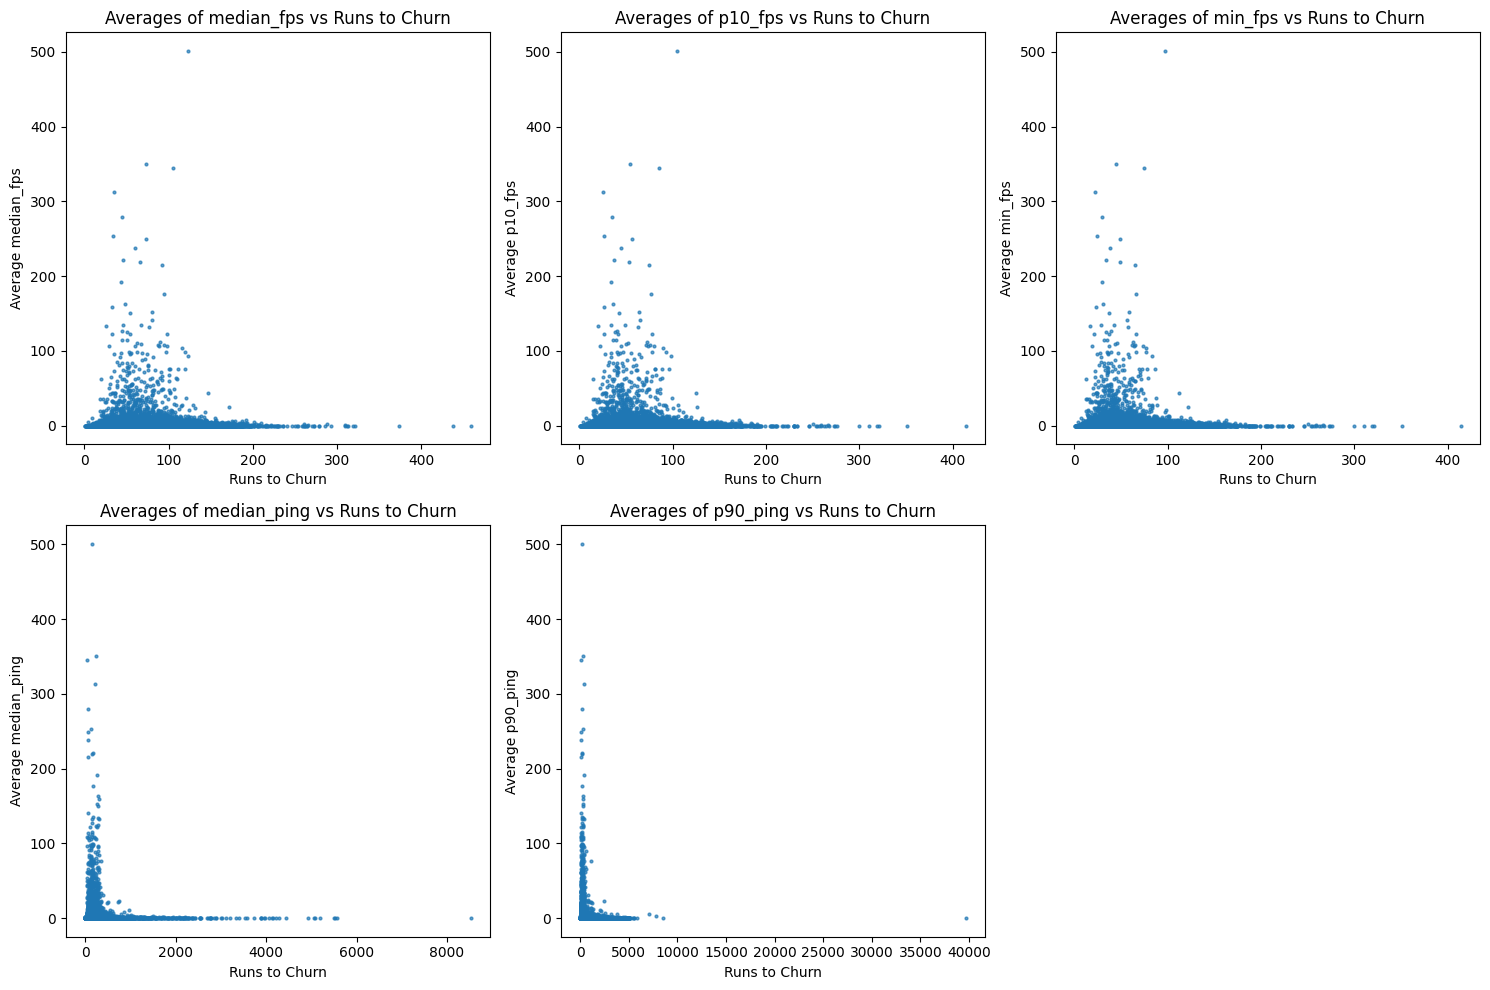

In [7]:
# Group data by userId and calculate averages for selected stats and the total number of runs till churn
grouped = df.groupby("userId").agg({
    "median_fps": "mean",
    "p10_fps": "mean",
    "min_fps": "mean",
    "median_ping": "mean",
    "p90_ping": "mean",
    "runs_to_churn": "max"
}).reset_index()

# Plot averages for each stat against the number of dungeons they will run till churn
stats = ["median_fps", "p10_fps", "min_fps", "median_ping", "p90_ping"]

plt.figure(figsize=(15, 10))
for i, stat in enumerate(stats, 1):
    plt.subplot(2, 3, i)
    plt.scatter( grouped[stat],grouped["runs_to_churn"], alpha=0.7, s = 4)
    plt.title(f"Averages of {stat} vs Runs to Churn")
    plt.xlabel("Runs to Churn")
    plt.ylabel(f"Average {stat}")

plt.tight_layout()
plt.show()


In [8]:
fps_bins = [0, 20, 30, 60, 120, float('inf')]
fps_labels = ['0-20 FPS', '20-30 FPS', '30-60 FPS', '60-120 FPS', '120+ FPS']
ping_bins = [0, 30, 60, 100, 200, float('inf')]
ping_labels = ['0-30 Ping', '30-60 Ping', '60-100 Ping', '100-200 Ping', '200+ Ping']

df.loc[:, 'median_fps_category'] = pd.cut(
    df['median_fps'], 
    bins=fps_bins, 
    labels=fps_labels
)
df.loc[:, 'p10_fps_category'] = pd.cut(
    df['p10_fps'], 
    bins=fps_bins, 
    labels=fps_labels
)
df.loc[:, 'min_fps_category'] = pd.cut(
    df['min_fps'], 
    bins=fps_bins, 
    labels=fps_labels
)
df.loc[:, 'median_ping_category'] = pd.cut(
    df['median_ping'], 
    bins=ping_bins, 
    labels=ping_labels
)
df.loc[:, 'p90_ping_category'] = pd.cut(
    df['p90_ping'], 
    bins=ping_bins, 
    labels=ping_labels
)

categories = ['median_fps_category','p10_fps_category','median_ping_category','p90_ping_category', 'min_fps_category']

In [9]:
print(df['runs_to_churn'].isnull().sum())  # Count missing values
print(df['runs_to_churn'].unique())       # Check for unexpected values

0
[  5   4   3   2   1   0   6   8   7  38  37  36  35  34  33  32  31  30
  29  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13  12
  11  10   9  58  57  56  55  54  53  52  51  50  49  48  47  46  45  44
  43  42  41  40  39  76  75  74  73  72  71  70  69  68  67  66  65  64
  63  62  61  60  59 501 500 499 498 497 496 495 494 493 492 491 490 489
 488 487 486 485 484 483 482 481 480 479 478 477 476 475 474 473 472 471
 470 469 468 467 466 465 464 463 462 461 460 459 458 457 456 455 454 453
 452 451 450 449 448 447 446 445 444 443 442 441 440 439 438 437 436 435
 434 433 432 431 430 429 428 427 426 425 424 423 422 421 420 419 418 417
 416 415 414 413 412 411 410 409 408 407 406 405 404 403 402 401 400 399
 398 397 396 395 394 393 392 391 390 389 388 387 386 385 384 383 382 381
 380 379 378 377 376 375 374 373 372 371 370 369 368 367 366 365 364 363
 362 361 360 359 358 357 356 355 354 353 352 351 350 349 348 347 346 345
 344 343 342 341 340 339 338 337 336 335 334 333 

/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_80432/3359203431.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.00%
(740)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data.loc[row, col] = f"{heatmap_data_normalized.loc[row, col]:.2%}\n({heatmap_data.loc[row, col]})"
/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_80432/3359203431.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.54%
(230)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data.loc[row, col] = f"{heatmap_data_normalized.loc[row, col]:.2%}\n({heatmap_data.loc[row, col]})"
/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_80432/3359203431.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and 

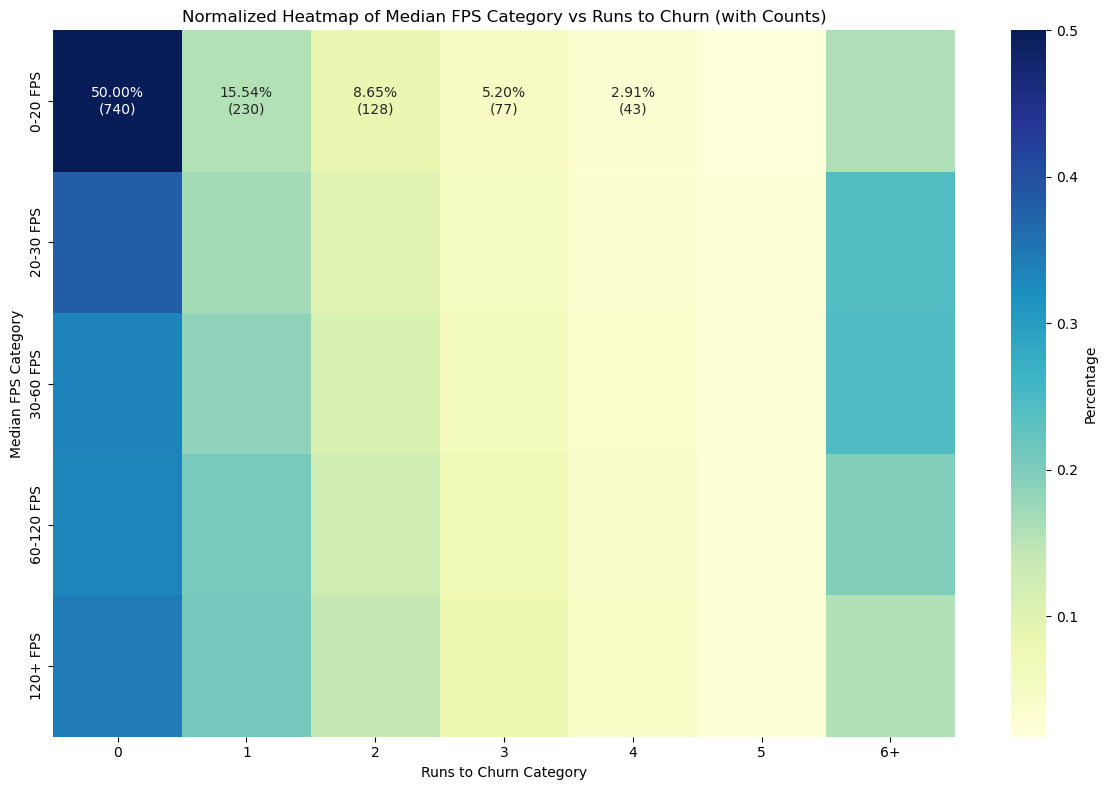

In [10]:
churn_bins = [-1,0, 1, 2, 3, 4, 5, float('inf')]
churn_labels = ['0','1', '2', '3', '4', '5', '6+']

# Bucket churn metrics
df['runs_to_churn_category'] = pd.cut(
    df['runs_to_churn'],
    bins=churn_bins,
    labels=churn_labels
)

# Create a heatmap for median_fps_category vs runs_to_churn_category
heatmap_data = df.pivot_table(
    index='median_fps_category',
    columns='runs_to_churn_category',
    aggfunc='size',
    fill_value=0,
    observed = False
)

# Normalize the heatmap data by row (percentage)
heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Combine normalized percentages and raw counts into a single DataFrame
annot_data = heatmap_data_normalized.copy()
for row in heatmap_data.index:
    for col in heatmap_data.columns:
        annot_data.loc[row, col] = f"{heatmap_data_normalized.loc[row, col]:.2%}\n({heatmap_data.loc[row, col]})"

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data_normalized, 
    annot=annot_data, 
    fmt="", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Percentage'}
)
plt.title("Normalized Heatmap of Median FPS Category vs Runs to Churn (with Counts)")
plt.xlabel("Runs to Churn Category")
plt.ylabel("Median FPS Category")
plt.tight_layout()
plt.show()


In [11]:
annot_data

runs_to_churn_category,0,1,2,3,4,5,6+
median_fps_category,,,,,,,
0-20 FPS,50.00%\n(740),15.54%\n(230),8.65%\n(128),5.20%\n(77),2.91%\n(43),1.76%\n(26),15.95%\n(236)
20-30 FPS,37.81%\n(1727),16.79%\n(767),9.83%\n(449),5.50%\n(251),3.48%\n(159),2.32%\n(106),24.26%\n(1108)
30-60 FPS,33.45%\n(11750),18.58%\n(6529),11.10%\n(3901),6.25%\n(2196),3.78%\n(1328),2.44%\n(858),24.39%\n(8570)
60-120 FPS,33.30%\n(18220),20.58%\n(11258),12.56%\n(6874),7.23%\n(3954),4.12%\n(2253),2.56%\n(1402),19.65%\n(10754)
120+ FPS,34.68%\n(2418),20.96%\n(1461),13.91%\n(970),7.60%\n(530),4.52%\n(315),2.61%\n(182),15.72%\n(1096)


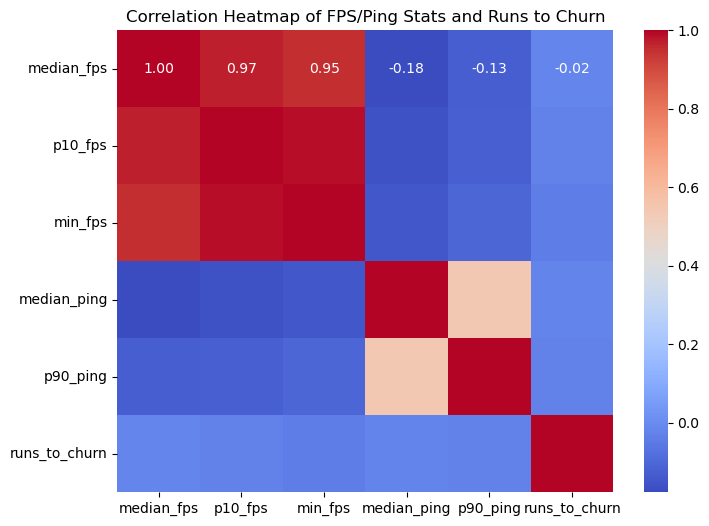

In [12]:
# Compute correlation matrix
correlation_matrix = grouped[["median_fps", "p10_fps", "min_fps", "median_ping", "p90_ping", "runs_to_churn"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of FPS/Ping Stats and Runs to Churn")
plt.show()

runs_to_churn_category                0                1               2  \
median_fps_category                                                        
0-20 FPS                  50.00%\n(740)    15.54%\n(230)    8.65%\n(128)   
20-30 FPS                37.81%\n(1727)    16.79%\n(767)    9.83%\n(449)   
30-60 FPS               33.45%\n(11750)   18.58%\n(6529)  11.10%\n(3901)   
60-120 FPS              33.30%\n(18220)  20.58%\n(11258)  12.56%\n(6874)   
120+ FPS                 34.68%\n(2418)   20.96%\n(1461)   13.91%\n(970)   

runs_to_churn_category              3              4              5  \
median_fps_category                                                   
0-20 FPS                  5.20%\n(77)    2.91%\n(43)    1.76%\n(26)   
20-30 FPS                5.50%\n(251)   3.48%\n(159)   2.32%\n(106)   
30-60 FPS               6.25%\n(2196)  3.78%\n(1328)   2.44%\n(858)   
60-120 FPS              7.23%\n(3954)  4.12%\n(2253)  2.56%\n(1402)   
120+ FPS                 7.60%\n(530)   4

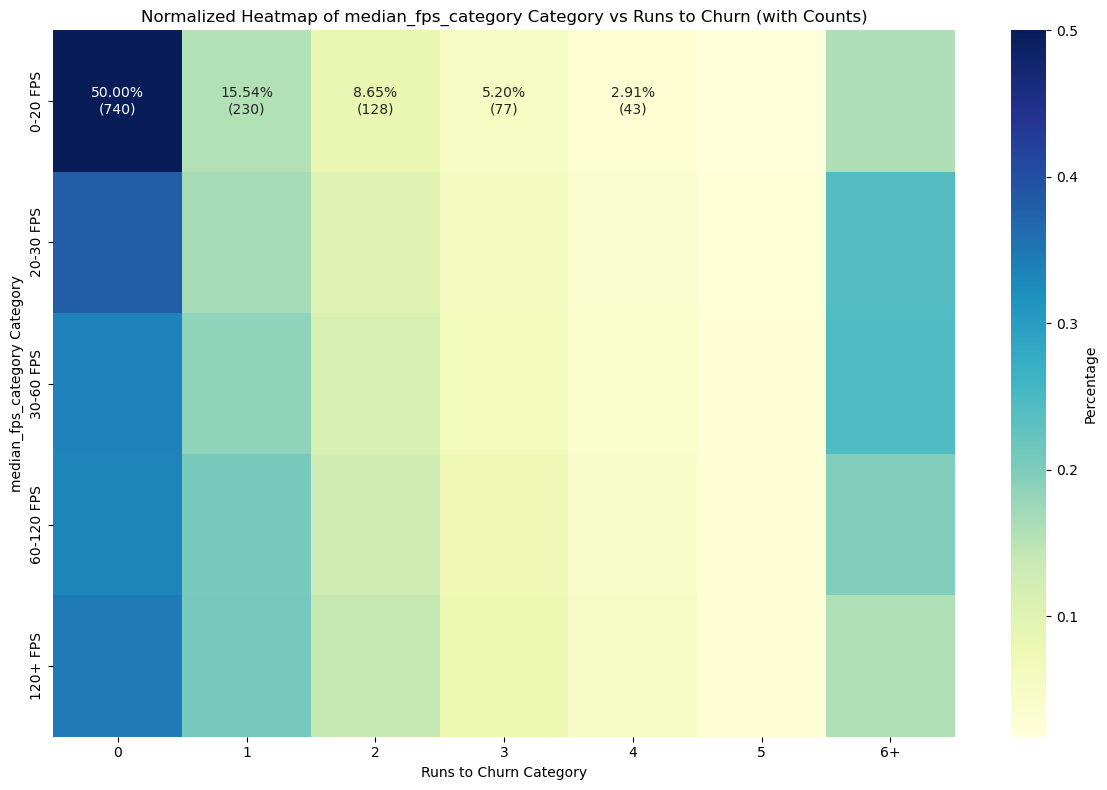

runs_to_churn_category                0               1               2  \
p10_fps_category                                                          
0-20 FPS                 39.89%\n(1559)   16.91%\n(661)   10.06%\n(393)   
20-30 FPS                34.31%\n(3263)  16.96%\n(1613)   10.25%\n(975)   
30-60 FPS               33.29%\n(15900)  19.22%\n(9178)  11.53%\n(5509)   
60-120 FPS              33.62%\n(12978)  21.21%\n(8187)  13.08%\n(5049)   
120+ FPS                 37.48%\n(1155)   19.66%\n(606)   12.85%\n(396)   

runs_to_churn_category              3              4              5  \
p10_fps_category                                                      
0-20 FPS                 5.58%\n(218)   3.51%\n(137)    2.20%\n(86)   
20-30 FPS                5.75%\n(547)   3.59%\n(341)   2.30%\n(219)   
30-60 FPS               6.59%\n(3149)  3.86%\n(1845)  2.56%\n(1222)   
60-120 FPS              7.45%\n(2875)  4.26%\n(1646)   2.51%\n(970)   
120+ FPS                 7.11%\n(219)   4.19%\n(

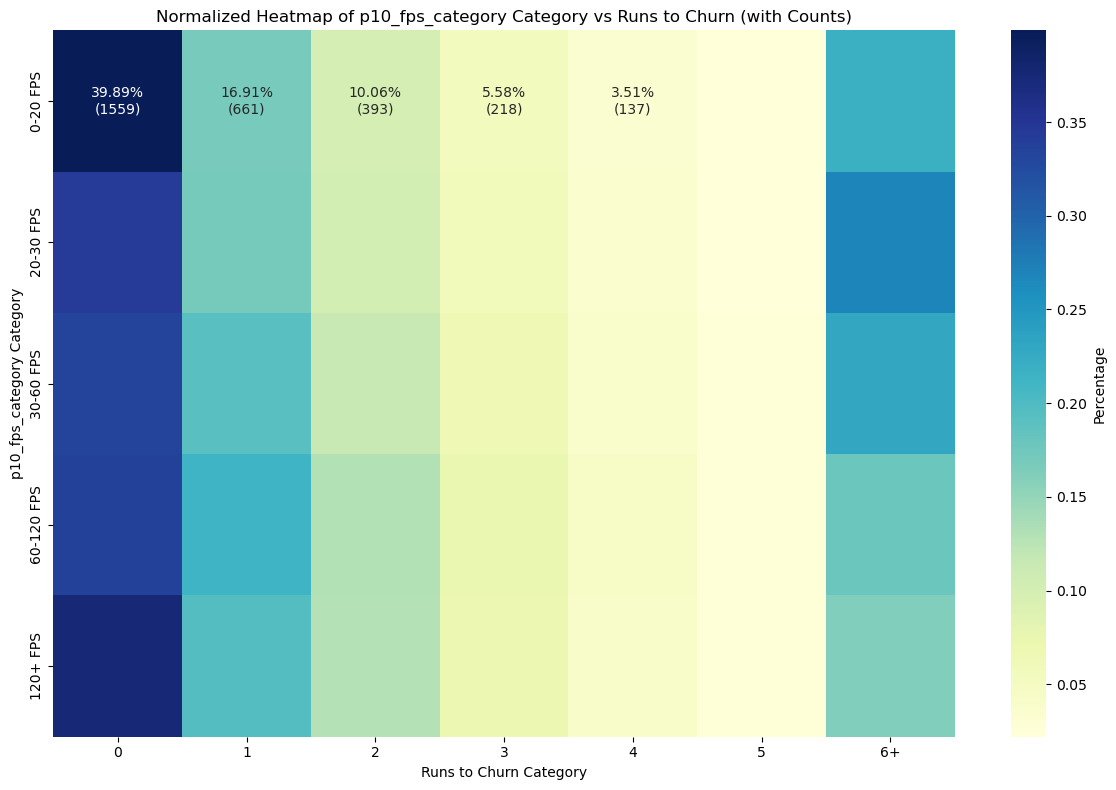

runs_to_churn_category                0               1               2  \
median_ping_category                                                      
0-30 Ping                   10.00%\n(1)      0.00%\n(0)     30.00%\n(3)   
30-60 Ping               25.90%\n(1201)   18.03%\n(836)   10.89%\n(505)   
60-100 Ping              31.48%\n(4389)  20.22%\n(2820)  12.21%\n(1703)   
100-200 Ping            34.00%\n(15646)  19.97%\n(9190)  12.15%\n(5590)   
200+ Ping               35.35%\n(13387)  19.44%\n(7362)  11.87%\n(4496)   

runs_to_churn_category              3              4              5  \
median_ping_category                                                  
0-30 Ping                 20.00%\n(2)    10.00%\n(1)    10.00%\n(1)   
30-60 Ping               5.82%\n(270)   3.62%\n(168)   2.18%\n(101)   
60-100 Ping              6.77%\n(944)   3.92%\n(546)   2.55%\n(356)   
100-200 Ping            6.84%\n(3147)  3.92%\n(1804)  2.43%\n(1118)   
200+ Ping               6.94%\n(2630)  4.14%\n(1

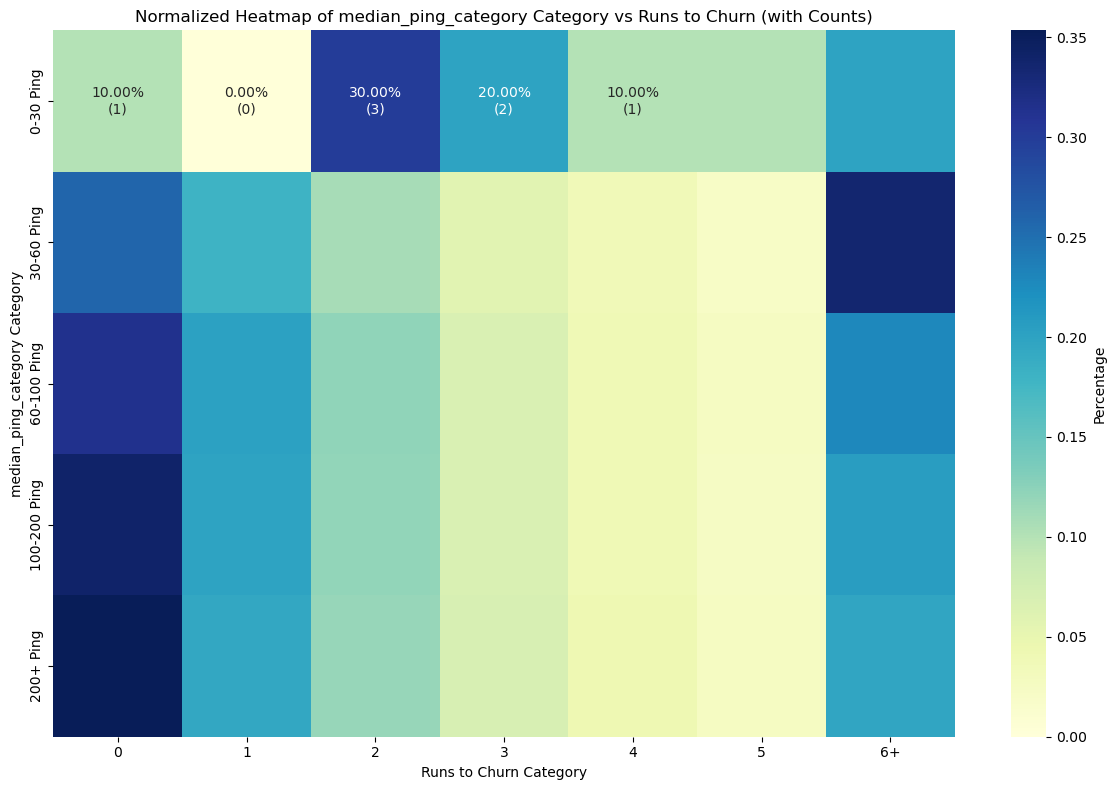

runs_to_churn_category                0                1               2  \
p90_ping_category                                                          
0-30 Ping                    0.00%\n(0)       0.00%\n(0)      0.00%\n(0)   
30-60 Ping                17.36%\n(242)    12.20%\n(170)     6.96%\n(97)   
60-100 Ping              29.52%\n(2730)   20.04%\n(1853)  12.08%\n(1117)   
100-200 Ping            32.60%\n(13103)   20.10%\n(8079)  12.25%\n(4924)   
200+ Ping               36.05%\n(18714)  19.51%\n(10130)  11.90%\n(6177)   

runs_to_churn_category              3              4              5  \
p90_ping_category                                                     
0-30 Ping                100.00%\n(1)     0.00%\n(0)     0.00%\n(0)   
30-60 Ping                4.02%\n(56)    2.30%\n(32)    2.22%\n(31)   
60-100 Ping              6.63%\n(613)   3.99%\n(369)   2.29%\n(212)   
100-200 Ping            6.95%\n(2792)  3.89%\n(1563)   2.48%\n(995)   
200+ Ping               6.82%\n(3543)  4.

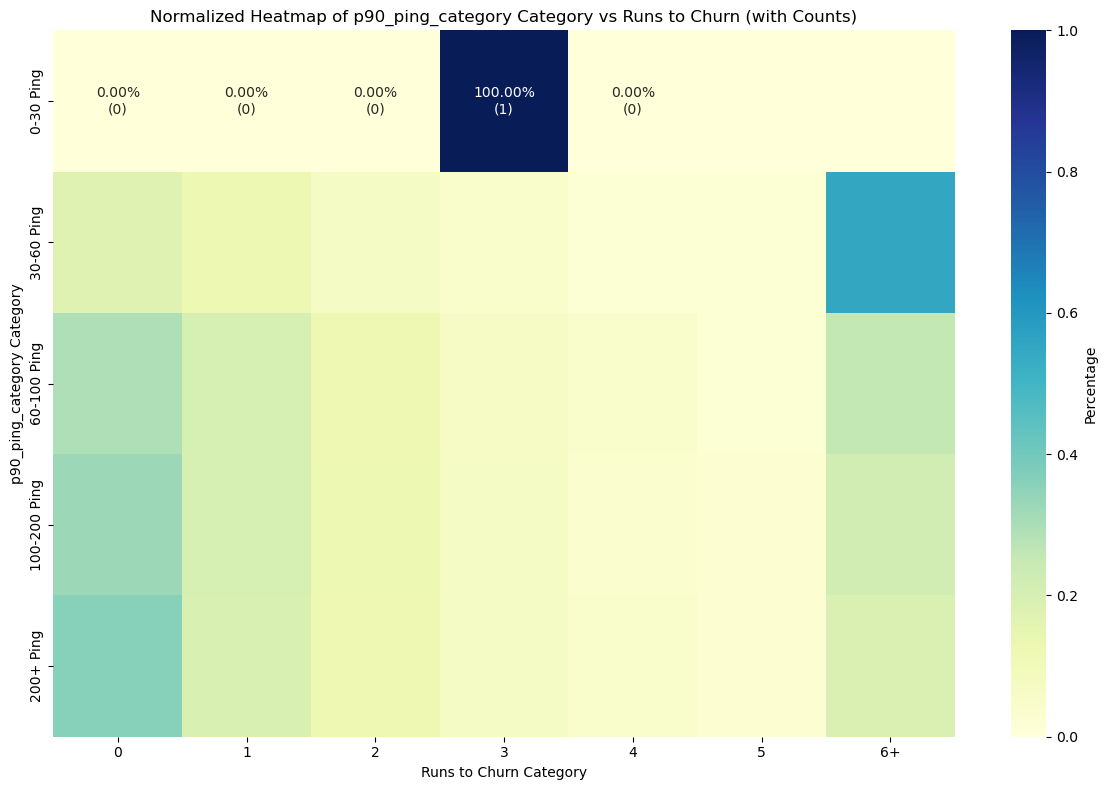

runs_to_churn_category                0                1               2  \
min_fps_category                                                           
0-20 FPS                 35.94%\n(2062)    15.30%\n(878)    9.18%\n(527)   
20-30 FPS                33.12%\n(4165)   16.80%\n(2113)  10.05%\n(1264)   
30-60 FPS               33.06%\n(16922)  19.77%\n(10118)  11.85%\n(6066)   
60-120 FPS              34.82%\n(10798)   21.69%\n(6726)  13.47%\n(4178)   
120+ FPS                  38.56%\n(908)    17.41%\n(410)   12.19%\n(287)   

runs_to_churn_category              3              4              5  \
min_fps_category                                                      
0-20 FPS                 5.32%\n(305)   3.28%\n(188)   2.30%\n(132)   
20-30 FPS                5.76%\n(724)   3.71%\n(466)   2.48%\n(312)   
30-60 FPS               6.73%\n(3445)  3.95%\n(2024)  2.49%\n(1276)   
60-120 FPS              7.68%\n(2383)  4.26%\n(1321)   2.55%\n(792)   
120+ FPS                 6.41%\n(151)    

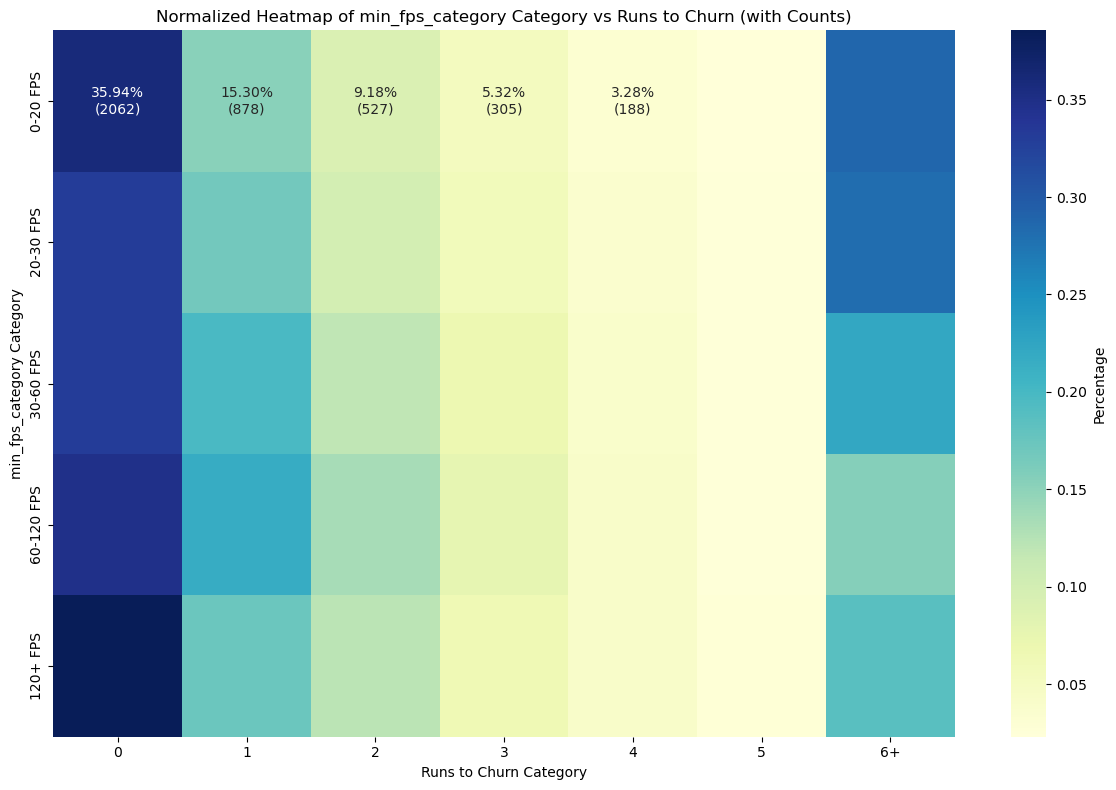

In [13]:
for category in categories:
    # Create a heatmap for median_fps_category vs runs_to_churn_category
    heatmap_data = df.pivot_table(
        index=category,
        columns='runs_to_churn_category',
        aggfunc='size',
        fill_value=0,
        observed = False
    )

    # Normalize the heatmap data by row (percentage)
    heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

    # Combine normalized percentages and raw counts into a single DataFrame
    # Explicitly set the dtype of annot_data to 'object' to handle strings
    annot_data = heatmap_data_normalized.copy().astype('object')
    for row in heatmap_data.index:
        for col in heatmap_data.columns:
            percentage = f"{heatmap_data_normalized.loc[row, col]:.2%}"
            count = f"({heatmap_data.loc[row, col]})"
            annot_data.loc[row, col] = f"{percentage}\n{count}"
    print(annot_data)
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data_normalized, 
        annot=annot_data, 
        fmt="", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Percentage'}
    )
    plt.title(f"Normalized Heatmap of {category} Category vs Runs to Churn (with Counts)")
    plt.xlabel("Runs to Churn Category")
    plt.ylabel(f"{category} Category")
    plt.tight_layout()
    plt.show()


In [18]:
""""
from sklearn.model_selection import GroupShuffleSplit,GroupKFold

n_splits = 5  # ~20% validation
splitter = GroupKFold(n_splits=n_splits)
groups = df["userId"]
X = df[features]  # Use the same df
y = df[target]  # Use the same df

for train_idx, val_idx in splitter.split(X, y, groups=groups):
    # Ensure validation sessions are AFTER training sessions for each user
    val_mask = df.iloc[val_idx].groupby("userId")["entryTime"].transform(
        lambda x: x > x.min()  # Validate on later sessions
    )
    val_idx = val_idx[val_mask]
    break  # Take first split for simplicity

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]"""

'"\nfrom sklearn.model_selection import GroupShuffleSplit,GroupKFold\n\nn_splits = 5  # ~20% validation\nsplitter = GroupKFold(n_splits=n_splits)\ngroups = df["userId"]\nX = df[features]  # Use the same df\ny = df[target]  # Use the same df\n\nfor train_idx, val_idx in splitter.split(X, y, groups=groups):\n    # Ensure validation sessions are AFTER training sessions for each user\n    val_mask = df.iloc[val_idx].groupby("userId")["entryTime"].transform(\n        lambda x: x > x.min()  # Validate on later sessions\n    )\n    val_idx = val_idx[val_mask]\n    break  # Take first split for simplicity\n\nX_train, X_val = X.iloc[train_idx], X.iloc[val_idx]\ny_train, y_val = y.iloc[train_idx], y.iloc[val_idx]'

In [19]:
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit,GroupKFold

# Ensure features are correctly created with historical values
for col in ["median_fps", "min_fps", "p10_fps", "median_ping", "p90_ping"]:
    df[f"historical_{col}"] = df.groupby("userId")[col].transform(
        lambda x: x.expanding().median().shift(1)  # Use only prior sessions
    )

# Fill NaNs in historical features
for col in ["historical_median_fps", "historical_min_fps", "historical_p10_fps", "historical_median_ping", "historical_p90_ping"]:
    df[col].fillna(df[col].median(), inplace=True)  # Use median or another value

# Define feature set and target
features = [f"historical_{col}" for col in ["median_fps", "min_fps", "p10_fps", "median_ping", "p90_ping"]]
target = "runs_to_churn_category"

X = df[features]
y = df[target]

# Encode the target variable BEFORE splitting
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode full dataset first

# Ensure that X and y_encoded have no NaNs (to avoid errors)
X = X.fillna(X.median())  # Fill NaNs in feature columns
y_encoded = np.array(y_encoded)  # Convert y to NumPy array for indexing safety

# Define GroupKFold splitting
n_splits = 5  # ~20% validation
splitter = GroupKFold(n_splits=n_splits)
groups = df["userId"]

# Perform train-test split ensuring validation sessions come after training
for train_idx, val_idx in splitter.split(X, y_encoded, groups=groups):
    val_mask = df.iloc[val_idx].groupby("userId")["entryTime"].transform(
        lambda x: x > x.min()  # Validate only on later sessions
    ).values  # Convert to NumPy array
    
    val_idx = val_idx[val_mask]  # Apply boolean mask to get filtered indices
    break  # Take first split for simplicity

# Create final train and validation sets
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]



/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_80432/3873381324.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)  # Use median or another value


In [20]:


# Print the mapping of classes
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
def objective(trial):
    # Define the search space for hyperparameters
    param = {
        "verbosity": 0,
        "objective": "multi:softprob",  # Use softprob for multi-class probabilities
        "tree_method": "hist",  # Use "gpu_hist" if you have GPU available
        "num_class": 7,  # Number of classes in the target
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True)
    }

    # Update the number of classes
    param["num_class"] = len(np.unique(y_train))
    # Create and train the XGBoost Classifier
    model = xgb.XGBClassifier(**param,
                              eval_metric = "mlogloss",
                              early_stopping_rounds=50,
)
    # Train the model
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False  # Keep training logs silent
    )

    # Generate predictions and compute log loss on the validation set
    y_pred = model.predict_proba(X_val)
    log_loss_val = log_loss(y_val, y_pred)  # Multi-class log loss

    return log_loss_val

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Print best trial details
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  RMSE:", trial.value)
print("  Params:", trial.params)

# Train a final model with the best parameters
best_params = study.best_params


[I 2025-02-24 12:05:44,342] A new study created in memory with name: no-name-4ca4980b-e1d7-4f9b-a361-fc1e54c38c16


Class mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6+': 6}


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-02-24 12:05:46,629] Trial 0 finished with value: 1.5608578994521771 and parameters: {'n_estimators': 810, 'max_depth': 4, 'learning_rate': 0.12021034044506089, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 1.775273748654829e-06, 'reg_lambda': 0.00017197051362115138, 'gamma': 7.722158174595305e-08}. Best is trial 0 with value: 1.5608578994521771.
[I 2025-02-24 12:05:49,692] Trial 1 finished with value: 1.6315108268847853 and parameters: {'n_estimators': 265, 'max_depth': 12, 'learning_rate': 0.08059715218431782, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 1.6170210497305878e-05, 'reg_lambda': 0.003102581632436479, 'gamma': 0.022306462313789615}. Best is trial 0 with value: 1.5608578994521771.
[I 2025-02-24 12:06:02,822] Trial 2 finished with value: 1.6609852435911254 and parameters: {'n_estimators': 428, 'max_depth': 10, 'learning_rate': 0.003381564346548558, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 2.385898263224766e-07, 'reg_lambda': 0.5631

In [21]:
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.214225956766416e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10583517383608523, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=856, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
num_classes = len(np.unique(label_encoder.fit_transform(y_train)))

In [23]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.214225956766416e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10583517383608523, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=856, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

For class: 0


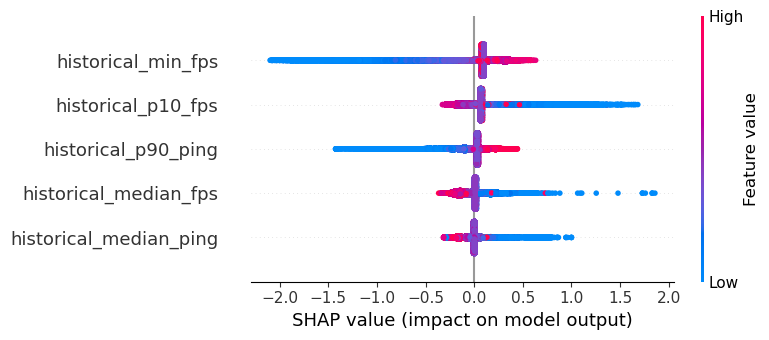

For class: 1


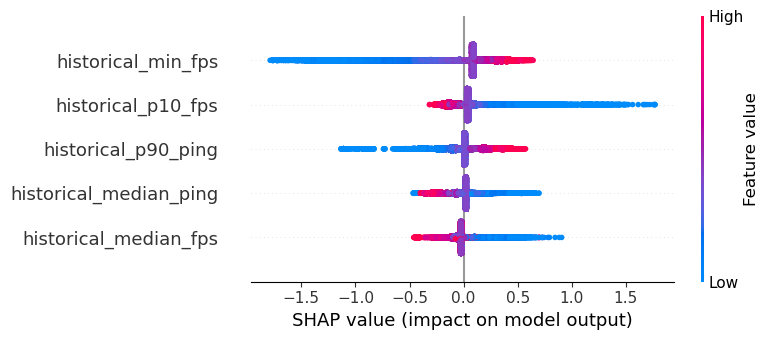

For class: 2


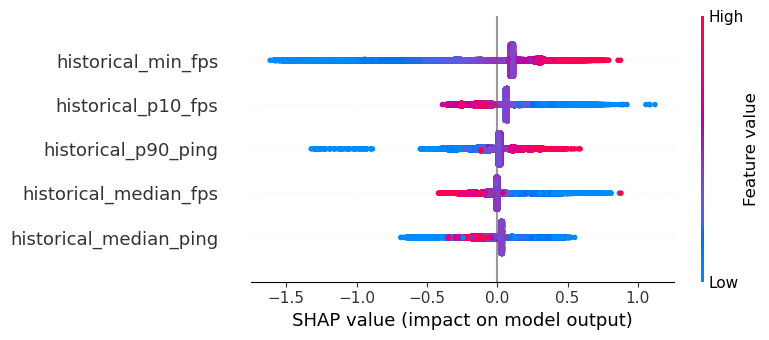

For class: 3


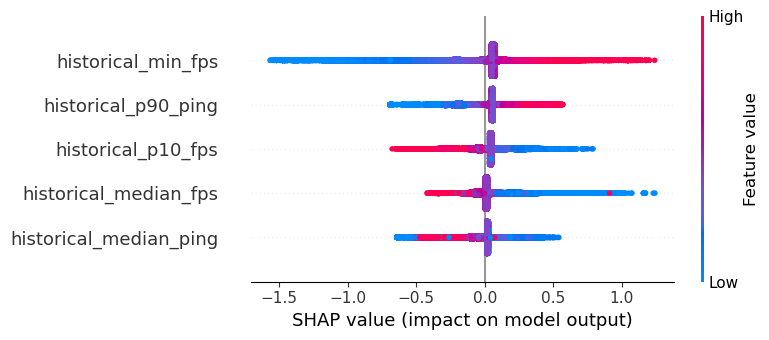

For class: 4


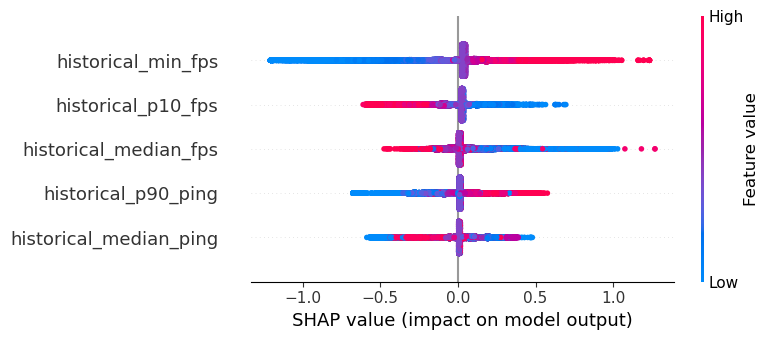

For class: 5


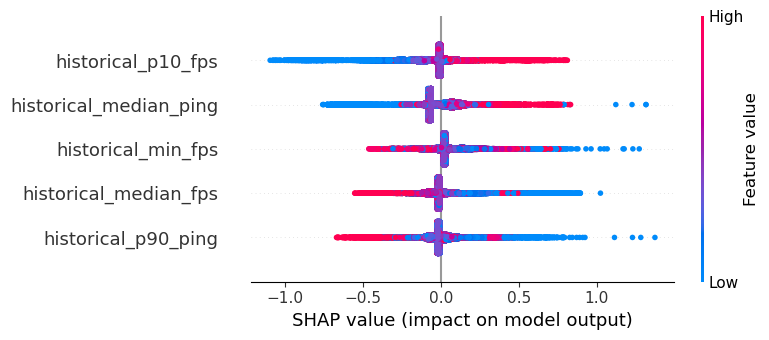

For class: 6


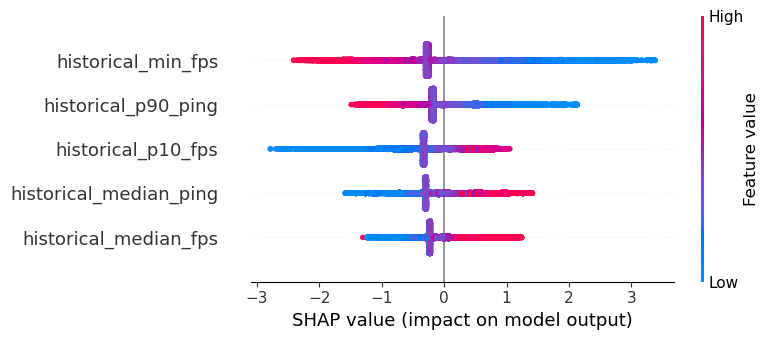

In [24]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values (use `explainer` directly for multi-class models)
shap_values = explainer(X)
for i in range(num_classes):
    # Ensure SHAP returns a list for multi-class problems
    if isinstance(shap_values, list):
        # Extract SHAP values for class 7 (index 6)
        class_7_shap_values = shap_values[i]
    else:
        # Use the SHAP values directly for the desired class
        class_7_shap_values = shap_values[..., i]



    # Ensure X is a Pandas DataFrame (if not already)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Plot SHAP summary plot for class 7
    print(f'For class: {label_encoder.classes_[i]}')

    shap.summary_plot(class_7_shap_values, X)

In [130]:
df[features].corr()

,historical_median_fps,historical_min_fps,historical_p10_fps,historical_median_ping,historical_p90_ping
historical_median_fps,1.000000,0.951570,0.974818,-0.170811,-0.147188
historical_min_fps,0.951570,1.000000,0.982754,-0.141047,-0.123357
historical_p10_fps,0.974818,0.982754,1.000000,-0.158634,-0.146062
historical_median_ping,-0.170811,-0.141047,-0.158634,1.000000,0.607885
historical_p90_ping,-0.147188,-0.123357,-0.146062,0.607885,1.000000
